In [90]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [86]:
df = pd.DataFrame.from_csv('labeledTrainData.tsv', sep='\t', encoding='utf-8')
df.head()

,sentiment,review
id,,
5814_8,1,With all this stuff going down at the moment w...
2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
7759_3,0,The film starts with a manager (Nicholas Bell)...
3630_4,0,It must be assumed that those who praised this...
9495_8,1,Superbly trashy and wondrously unpretentious 8...


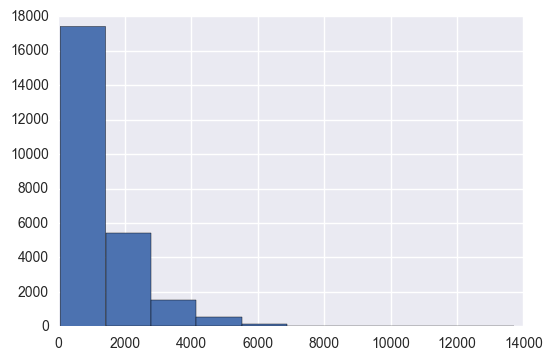

In [67]:
df['review'].apply(len).hist()

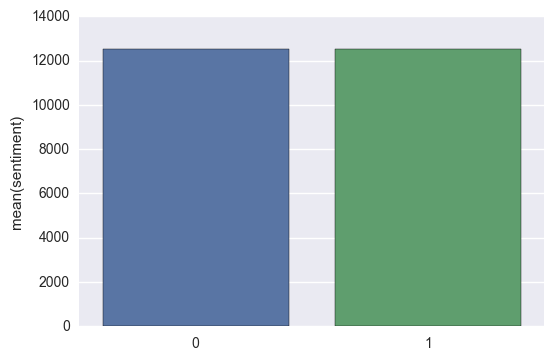

In [68]:
sns.barplot(y=df['sentiment'].value_counts(), x=[0,1])

In [87]:
X, y = [df[col].values for col in ['review', 'sentiment']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [88]:
class_names = ['negative', 'positive']

### Bag of Words

In [57]:
# source: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

In [58]:
sum(X_train_counts[0,:].toarray()[0])

161

In [60]:
# idf tf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=True)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(17500, 64739)

In [61]:
# train
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [62]:
# sanity check
docs_new = ['This is absolutely terrible, the worst ever.', 'A thrilling and scintillating debut, a triumph.']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, class_names[category]))

'This is absolutely terrible, the worst ever.' => negative
'A thrilling and scintillating debut, a triumph.' => positive


In [63]:
# as pipeline
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
text_clf = text_clf.fit(X_train, y_train)

In [65]:
# evaluate
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.86240000000000006

### Features as sequence of words

In [70]:
X_train[0]

'I saw this pilot when it was first shown, and I\'m sure countless \\Spirit\\" fans hate it, because, like Batman, the Green Hornet etc., it took the character in the direction of \\"camp\\". But I evidently never got enough of Batman, because I thought it was entertaining, in some of the same ways as that show. There are two parts that stay with me. First, when Denny\'s partner has been fatally wounded, and he makes a dramatic speech about how he always stood for the law, and obeying the exact letter of it. Then, he says something like, \\"Boy, was I stupid!\\" Which is his way of telling Denny to become a vigilante instead, which he does (though the TV Batman kind). Then, there\'s the scene where he tries to seduce the villainess into letting him go by kissing her, but she isn\'t fooled, because he\'s too honest to kiss her convincingly ! This was a great example of \\"camp\\", that was also \\"underplayed\\", by both the actor and actress."'

In [162]:
import nltk
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
def tokenize(text, stemmer=None):
    tokens = nltk.word_tokenize(doc)
    tokens = [i for i in tokens if i not in string.punctuation]
    return [stemmer.stem(t) if stemmer else t for t in tokens]

words = [token for doc in X_train for token in tokenize(doc, stemmer)]
fdist = nltk.FreqDist(words)

In [163]:
NUM_WORDS = 5000
word_dict = {w:idx for idx, (w, _) in enumerate(fdist.most_common(NUM_WORDS))}
word_dict.items()[:10]

[(u'repris', 4631),
 (u'woodi', 2119),
 (u'better.', 3534),
 (u'talki', 4141),
 (u'foul', 3741),
 (u'four', 752),
 (u'protest', 3357),
 (u'sleep', 1092),
 (u'asian', 1974),
 (u'mansion', 2553)]

In [191]:
from keras.preprocessing import sequence

MAX_DOC_LEN = 500
UNKNOWN_WORD_IDX = -1

def encode_docs(docs, max_doc_len=500):
    encoded_doc = [[word_dict[t] if t in word_dict else UNKNOWN_WORD_IDX for t in tokenize(doc, stemmer)]
                       for doc in docs]
    # truncate and pad input sequences
    return sequence.pad_sequences(encoded_doc, maxlen=MAX_DOC_LEN)

X_train_enc, X_test_enc = map(encode_docs, [X_train, X_test])

In [171]:
# create model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

EMBEDDING_VECTOR_LEN = 32
model = Sequential()
model.add(Embedding(NUM_WORDS, EMBEDDING_VECTOR_LEN, input_length=MAX_DOC_LEN))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train_enc, y_train, validation_data=(X_test_enc, y_test), nb_epoch=3, batch_size=64)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 500, 32)       160000      embedding_input_1[0][0]          
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 100)           53200       embedding_1[0][0]                
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1)             101         lstm_1[0][0]                     
Total params: 213301
____________________________________________________________________________________________________
None


Exception: Input arrays should have the same number of samples as target arrays. Found 17500 input samples and 7500 target samples.